# Face Detection on Custom Dataset with Detectron2

Face detection is the task of finding (boundaries of) faces in images. This is useful for 
- security systems (the first step in recognizing a person)
- autofocus and smile detection for making great photos
- detecting age, race, and emotional state for markering (yep, we already live in that world)

The notebook is about doing the following:
- prepare a custom dataset for face detection with Detectron2
- use (close to) state-of-the-art models for object detection to find faces in images


## Detectron 2

[Detectron2](https://github.com/facebookresearch/detectron2) is a framework for building state-of-the-art object detection and image segmentation models. It is developed by the Facebook Research team. Detectron2 is a complete rewrite of the [first version](https://github.com/facebookresearch/Detectron).

Under the hood, Detectron2 uses PyTorch (compatible with the latest version(s)) and allows for [blazing fast training](https://detectron2.readthedocs.io/notes/benchmarks.html). 

The real power of Detectron2 lies in the HUGE amount of pre-trained models available at the [Model Zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md). 

### Installing Detectron2

In [0]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 276kB 9.0MB/s 


And download, compile, and install the Detectron2 package:

In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 4983 (delta 1), reused 8 (delta 1), pack-reused 4956
Receiving objects: 100% (4983/4983), 2.45 MiB | 4.69 MiB/s, done.
Resolving deltas: 100% (3548/3548), done.


Restart the notebook runtime to continue!

In [0]:
!pip install -q -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
pycocotools 2.0
torch 1.5.0+cu101
torchvision 0.6.0+cu101
detectron2 0.1.3


Imports

In [0]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Face Detection Data

Our dataset is provided by [Dataturks](https://dataturks.com/), and it is hosted on [Kaggle](https://www.kaggle.com/dataturks/face-detection-in-images). Here's an excerpt from the description:

> Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

The JSON file that contains the annotationas can be downloaded from Google Drive

In [0]:
!gdown --id 1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS

Downloading...
From: https://drive.google.com/uc?id=1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS
To: /content/face_detection.json
100% 274k/274k [00:00<00:00, 81.6MB/s]


Let's load the file into a Pandas dataframe:

In [0]:
faces_df = pd.read_json('face_detection.json', lines=True)
faces_df.head()

content  ... extras
0  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
3  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
4  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[5 rows x 3 columns]

Each line contains a single face annotation. Note that multiple lines might point to a single image (e.g. multiple faces per image).

## Data Preprocessing

The dataset contains only image URLs and annotations. We'll have to download the images. We'll also normalize the annotations, so it's easier to use them with Detectron2 later on:

In [0]:
os.makedirs("faces", exist_ok=True)

dataset = []

for index, row in tqdm(faces_df.iterrows(), total=faces_df.shape[0]):
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')

    image_name = f'face_{index}.jpeg'

    img.save(f'faces/{image_name}', "JPEG")
    
    annotations = row['annotation']
    for an in annotations:

      data = {}

      width = an['imageWidth']
      height = an['imageHeight']
      points = an['points']

      data['file_name'] = image_name
      data['width'] = width
      data['height'] = height

      data["x_min"] = int(round(points[0]["x"] * width))
      data["y_min"] = int(round(points[0]["y"] * height))
      data["x_max"] = int(round(points[1]["x"] * width))
      data["y_max"] = int(round(points[1]["y"] * height))

      data['class_name'] = 'face'

      dataset.append(data)
    

100%|██████████| 409/409 [03:28<00:00,  1.96it/s]


Let's put the data into a dataframe so we can have a better look:

In [0]:
df = pd.DataFrame(dataset)
df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [0]:
print(df.file_name.unique().shape[0], df.shape[0])

409 1132


We have a total of 409 images (a lot less than the promised 500) and 1132 annotations. Let's save them to the disk 

In [0]:
df.to_csv('annotations.csv', header=True, index=None)

### Data Exploration

Let's see some sample annotated data. We'll use OpenCV to load an image, add the bounding boxes, and resize it. We'll define a helper function to do it all:

In [0]:
def annotate_image(annotations, resize=True):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'faces/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

Let's start by showing some annotated images:

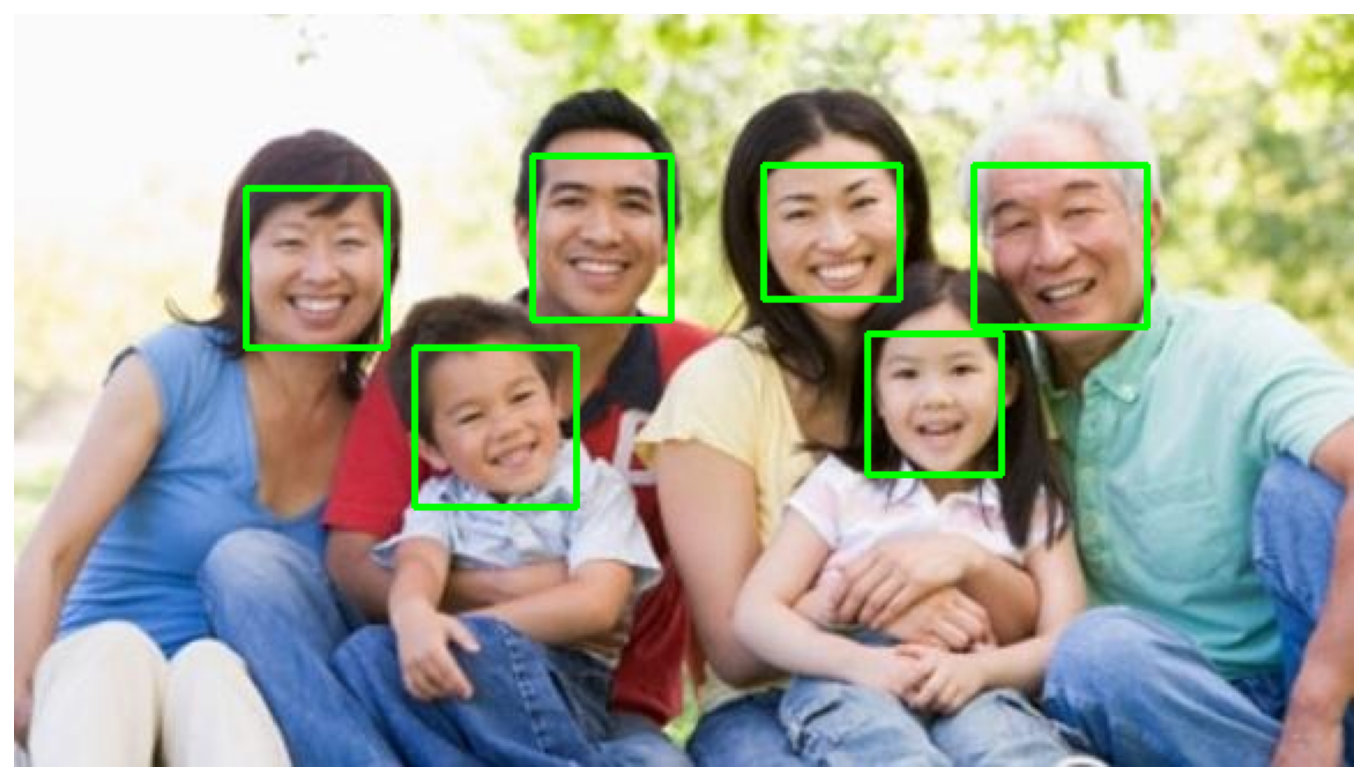

In [0]:
df = pd.read_csv('annotations.csv')
img_df = df[df.file_name == df.file_name.unique()[4]]
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

## Face Detection with Detectron 2

It is time to go through the steps of fine-tuning a model using a custom dataset. But first, let's save 5% of the data for testing:

In [0]:
IMAGES_PATH = 'faces'

unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

The classical train_test_split won't work here, cause we want a split amongst the file names. 

The next parts are written in a bit more generic way. Obviously, we have a single class - face. But adding more should be as simple as adding more annotations to the dataframe:

In [0]:
classes = df.class_name.unique().tolist()

Next, we'll write a function that converts our dataset into a format that is used by Detectron2:

We convert every annotation row to a single record with a list of annotations. You might also notice that we're building a polygon that is of the exact same shape as the bounding box. This is required for the image segmentation models in Detectron2.

In [0]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

You'll have to register your dataset into the dataset and metadata catalogues:

In [0]:
for d in ["train", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")

Unfortunately, evaluator for the test set is not included by default. We can easily fix that by writing our own trainer:

In [0]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

The evaluation results will be stored in the `coco_eval` folder if no folder is provided.

Fine-tuning a Detectron2 model is nothing like writing PyTorch code. We'll load a configuration file, change a few values, and start the training process. 

We'll use the Mask R-CNN X101-FPN model. It is pre-trained on the [COCO dataset](http://cocodataset.org/#home) and achieves very good performance. The downside is that it is slow to train.

Let's load the config file and the pre-trained model weights:

In [0]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

Specify the datasets (we registered those) we'll use for training and evaluation:

In [0]:
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

Except for the standard stuff (batch size, max number of iterations, and learning rate) we have a couple of interesting params:

- `WARMUP_ITERS` - the learning rate starts from 0 and goes to the preset one for this number of iterations
- `STEPS` - the checkpoints (number of iterations) at which the learning rate will be reduced by `GAMMA`

In [0]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

Finally, we'll specify the number of classes and the period at which we'll evaluate on the test set:

In [0]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

Time to train, using our custom trainer:

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/26 00:03:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:42, 10.2MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[05/26 00:04:41 d2.engine.train_loop]: Starting training from iteration 0
[05/26 00:05:16 d2.utils.events]:  eta: 0:44:21  iter: 19  total_loss: 1.853  loss_cls: 0.548  loss_box_reg: 0.324  loss_mask: 0.685  loss_rpn_cls: 0.226  loss_rpn_loc: 0.028  time: 1.7906  data_time: 0.0475  lr: 0.000020  max_mem: 11309M
[05/26 00:05:53 d2.utils.events]:  eta: 0:44:13  iter: 39  total_loss: 1.931  loss_cls: 0.519  loss_box_reg: 0.543  loss_mask: 0.627  loss_rpn_cls: 0.154  loss_rpn_loc: 0.026  time: 1.8037  data_time: 0.0230  lr: 0.000040  max_mem: 11309M
[05/26 00:06:29 d2.utils.events]:  eta: 0:43:55  iter: 59  total_loss: 1.757  loss_cls: 0.460  loss_box_reg: 0.593  loss_mask: 0.539  loss_rpn_cls: 0.109  loss_rpn_loc: 0.020  time: 1.8092  data_time: 0.0247  lr: 0.000060  max_mem: 11309M
[05/26 00:07:05 d2.utils.events]:  eta: 0:43:13  iter: 79  total_loss: 1.711  loss_cls: 0.438  loss_box_reg: 0.719  loss_mask: 0.473  loss_rpn_cls: 0.053  loss_rpn_loc: 0.020  time: 1.8013  data_time: 0.0254  

## Evaluating Object Detection Models

Evaluating object detection models is a bit different when compared to evaluating standard classification or regression models.

The main metric that will be used is IoU (intersection over union). It measures the overlap between two boundaries - the predicted and ground truth one. It can get values between 0 and 1.

$$\text{IoU}=\frac{\text{area of overlap}}{\text{area of union}}$$

Using IoU, one can define a threshold (e.g. >0.5) to classify whether a prediction is a true positive (TP) or a false positive (FP).

Now you can calculate average precision (AP) by taking the area under the precision-recall curve.

Now AP@X (e.g. AP50) is just AP at some IoU threshold. 

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir output

<IPython.core.display.Javascript object>

To avoid training everytime, the finetuned model can be downloaded from the following link:

In [0]:
!gdown --id 18Ev2bpdKsBaDufhVKf0cT6RmM3FjW3nL
!mv face_detector.pth output/model_final.pth

Downloading...
From: https://drive.google.com/uc?id=18Ev2bpdKsBaDufhVKf0cT6RmM3FjW3nL
To: /content/face_detector.pth
856MB [00:04, 183MB/s]


We can start making predictions by loading the model and setting a minimum threshold of 85% certainty at which we'll consider the predictions as correct:

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

Let's run the evaluator with the trained model:

In [0]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[05/26 00:58:39 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[05/26 00:58:39 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/26 00:58:39 d2.evaluation.evaluator]: Start inference on 21 images
[05/26 00:58:43 d2.evaluation.evaluator]: Inference done 11/21. 0.1959 s / img. ETA=0:00:02
[05/26 00:58:45 d2.evaluation.evaluator]: Total inference time: 0:00:03.576523 (0.223533 s / img per device, on 1 devices)
[05/26 00:58:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.195513 s / img per device, on 1 devices)
[05/26 00:58:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/26 00:58:45 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/26 00:58:45 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE 

OrderedDict([('bbox',
              {'AP': 26.73925959230817,
               'AP50': 68.4656113541252,
               'AP75': 20.906877127929718,
               'APl': 32.78386956973392,
               'APm': 24.871954496609547,
               'APs': 7.227722772277227}),
             ('segm',
              {'AP': 24.79031603471314,
               'AP50': 68.4656113541252,
               'AP75': 11.593305398347953,
               'APl': 31.228393948459644,
               'APm': 21.35699678042257,
               'APs': 8.712871287128712})])

## Finding Faces in Images

Next, let's create a folder and save all images with predicted annotations in the test set:

In [0]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.file_name.unique()

In [0]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1., 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

Let's have a look:

In [0]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]

Note that some faces have multiple bounding boxes with different degrees of certainty. 

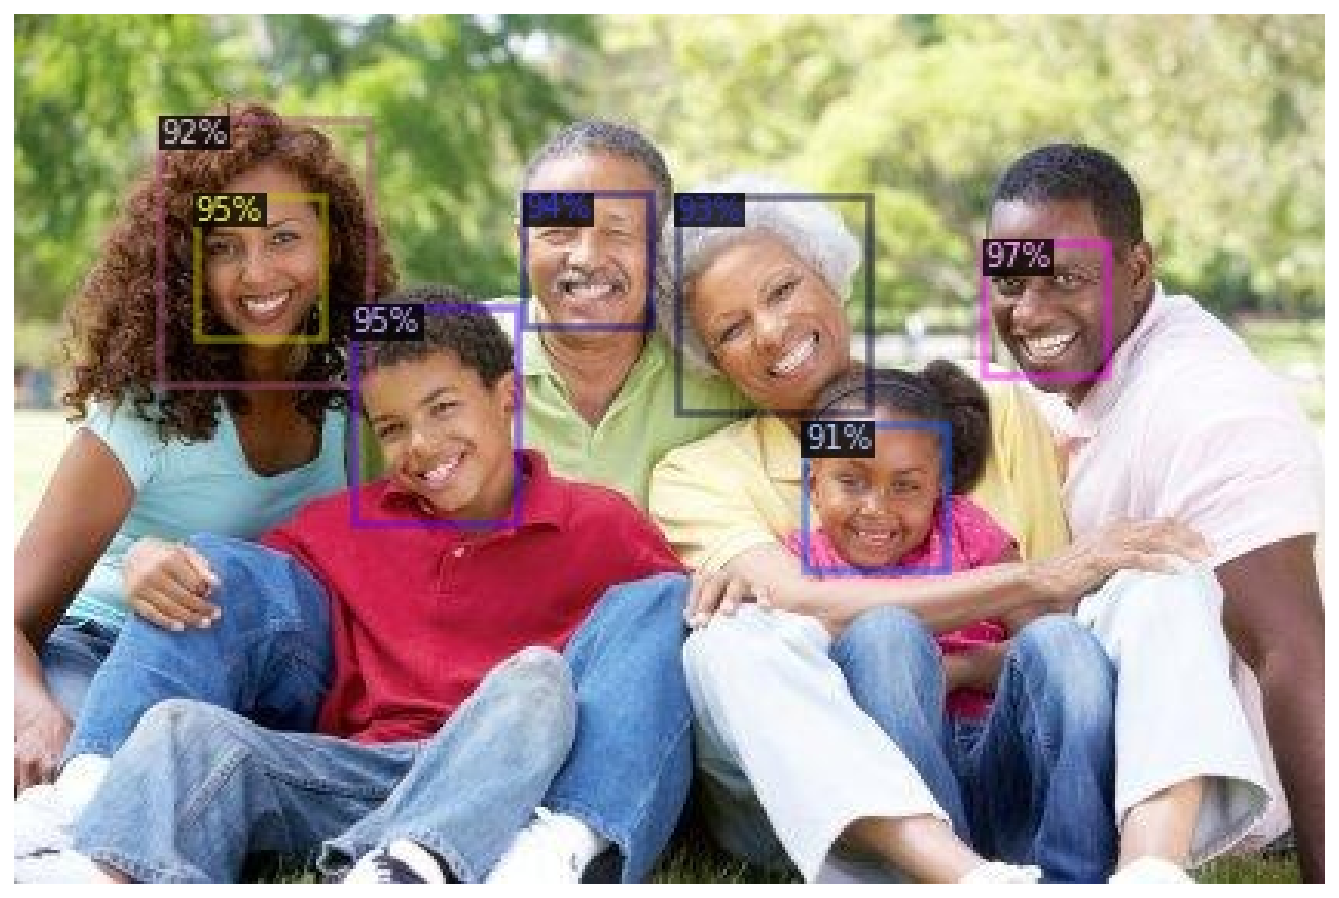

In [0]:
img = cv2.cvtColor(cv2.imread(annotated_images[1]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

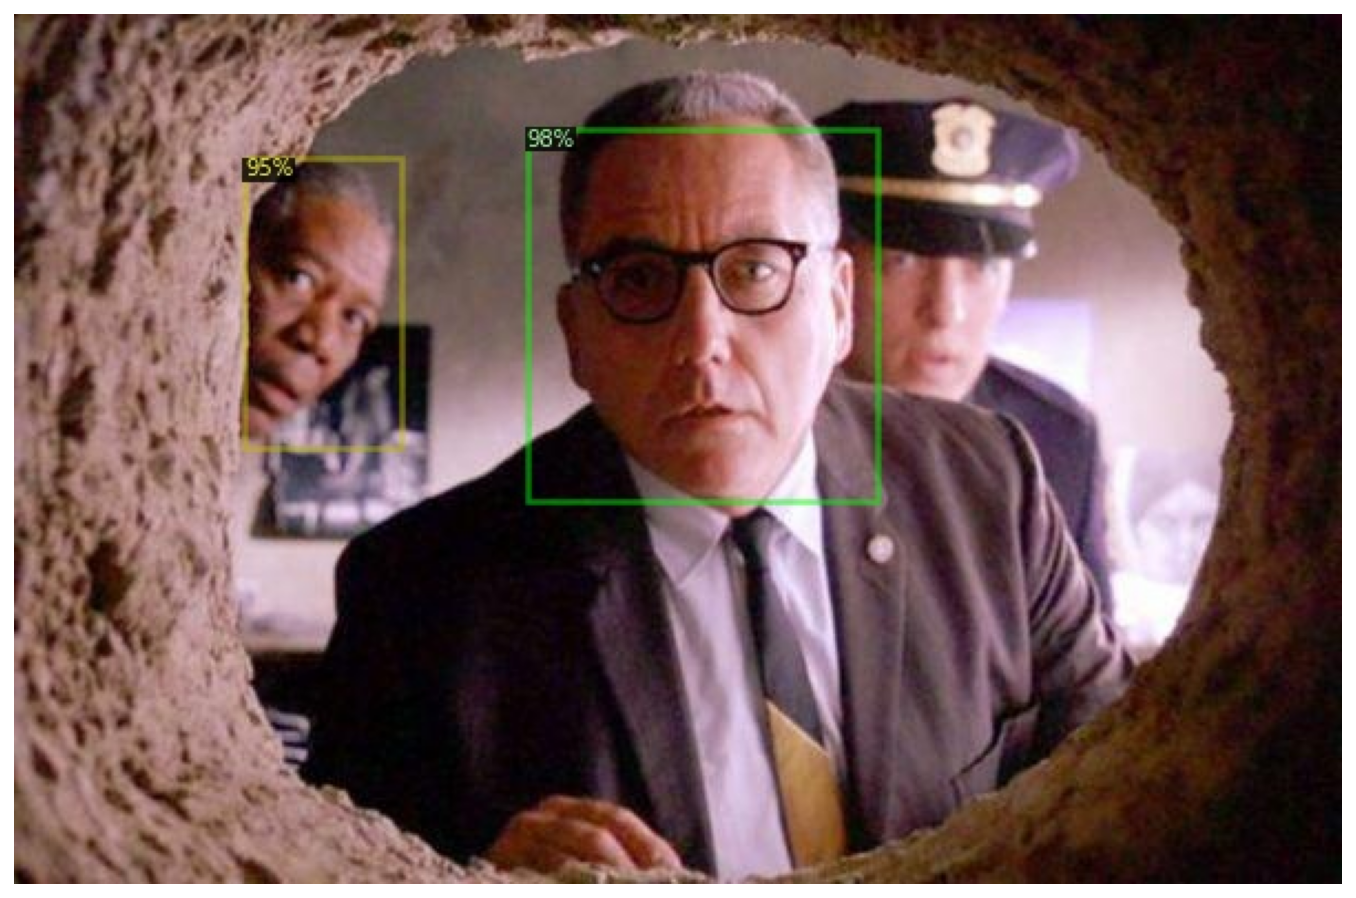

In [0]:
img = cv2.cvtColor(cv2.imread(annotated_images[3]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');